## IPEDS Accounting & Degree Trends (2019–2024)

**Goal:** Use IPEDS revised completions files to study:
- How many **accounting degrees** (CIP 52.0301) are awarded over time.
- How total degrees across **all majors** change over time.
- How **bachelor’s vs master’s** degrees change for all majors vs accounting.

This notebook will:
1. Load multiple years of revised IPEDS completions files.
2. Clean and standardize each file into a consistent format.
3. Stack all years into a single dataset.
4. Build summary tables and plots for:
   - Accounting degrees
   - All degrees
   - Degree level (bachelor’s vs master’s)



## 1. Confirm working directory and locate data files

We start by confirming where this notebook is running and what files are in
the `../data` folder (one level above `notebooks/`).


In [10]:
import os
from pathlib import Path

# Step 1 — Working directory
CWD = Path().resolve()
print("CWD:", CWD)

# Step 2 — Data folder is ALWAYS inside project root
DATA_DIR = CWD / "data"

print("\nData directory:", DATA_DIR)

print("Files in data/:")
for p in DATA_DIR.glob("*"):
    print(" •", p.name)



CWD: /Users/juliakelly/DataspellProjects/AC547_Final_Project

Data directory: /Users/juliakelly/DataspellProjects/AC547_Final_Project/data
Files in data/:
 • C2024_a.csv
 • c2019_a_rv.csv
 • occupation_age_cleaned.csv
 • c2021_a_rv.csv
 • c2020_a_rv.csv
 • national_M2023_dl (1).xlsx
 • national_M2021_dl.xlsx
 • national_M2022_dl (1).xlsx
 • national_M2024_dl (2).xlsx
 • C2023_a_rV.csv


In [12]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# We are in AC547_Final_Project
NOTEBOOK_DIR = Path(".").resolve()

# ✅ Use THIS folder's data subfolder
DATA_DIR = NOTEBOOK_DIR / "data"   # <--- change here

print("CWD:", NOTEBOOK_DIR)
print("Data directory:", DATA_DIR)

print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" •", p.name)



CWD: /Users/juliakelly/DataspellProjects/AC547_Final_Project
Data directory: /Users/juliakelly/DataspellProjects/AC547_Final_Project/data
Files in data/:
 • C2024_a.csv
 • c2019_a_rv.csv
 • occupation_age_cleaned.csv
 • c2021_a_rv.csv
 • c2020_a_rv.csv
 • national_M2023_dl (1).xlsx
 • national_M2021_dl.xlsx
 • national_M2022_dl (1).xlsx
 • national_M2024_dl (2).xlsx
 • C2023_a_rV.csv


## 2. Imports and helper function to clean a single IPEDS file

The function `clean_ipeds_completions()`:
- Infers the **year** from the filename.
- Standardizes column names (lowercase, underscores).
- Converts numeric-looking columns to numbers.
- Adds a `year` column to each row.


In [3]:
import re
import pandas as pd

from pathlib import Path  # already imported above, but harmless

def clean_ipeds_completions(path: str | Path) -> pd.DataFrame:
    """
    Read one IPEDS completions file and return a cleaned dataframe.
    - Standardizes column names
    - Converts numeric-looking columns to numeric
    - Adds a 'year' column inferred from the filename
    """
    path = Path(path)

    # Infer year from filename (first 4 digits like 2019, 2020, etc.)
    m = re.search(r"(20\d{2})", path.name)
    year = int(m.group(1)) if m else None

    # Read everything as string initially
    df = pd.read_csv(
        path,
        dtype=str,
        low_memory=False,
        na_values=[".", "NA", "N/A", "NULL", ""]
    )

    # Standardize column names
    df.columns = (
        df.columns.str.lower()
                  .str.strip()
                  .str.replace(r"[^\w]+", "_", regex=True)
                  .str.replace(r"_+", "_", regex=True)
                  .str.strip("_")
    )

    # Columns we want to keep as text (even if they look numeric)
    text_like_cols = {
        "unitid", "opeid", "cipcode", "majornum", "awlevel", "line"
    }

    # Convert other columns to numeric when appropriate
    for col in df.columns:
        if col in text_like_cols:
            continue

        sample = df[col].dropna().astype(str)
        if sample.empty:
            continue

        # Remove digits, decimal points, minus signs
        cleaned = sample.str.replace(r"[0-9\.\-]", "", regex=True)

        # If nothing but digits/.-, treat as numeric
        if (cleaned == "").all():
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add year column
    df["year"] = year

    return df


## 3. Load and clean all revised IPEDS files (2019, 2020, 2021, 2023, 2024)

Here we:
1. Build a list of the specific IPEDS files we want.
2. Apply `clean_ipeds_completions()` to each file.
3. Stack all years into a single dataframe `completions_all`.


In [4]:
# List of revised IPEDS completions files in the data folder
file_paths = [
    DATA_DIR / "c2019_a_rv.csv",
    DATA_DIR / "c2020_a_rv.csv",
    DATA_DIR / "c2021_a_rv.csv",
    DATA_DIR / "C2023_a_rV.csv",
    DATA_DIR / "C2024_a.csv",
]

frames = []
for path in file_paths:
    print(f"Loading and cleaning: {path.name}")
    frames.append(clean_ipeds_completions(path))

completions_all = pd.concat(frames, ignore_index=True)


Loading and cleaning: c2019_a_rv.csv
Loading and cleaning: c2020_a_rv.csv
Loading and cleaning: c2021_a_rv.csv
Loading and cleaning: C2023_a_RV.csv
Loading and cleaning: C2024_a.csv


## 4. Quick sanity checks on the stacked dataset

We verify:
- Number of rows and columns
- Years present in the `year` column
- A small sample of columns and rows


In [5]:
print("Rows:", len(completions_all))
print("Columns:", len(completions_all.columns))
print("Years in data:", sorted(completions_all["year"].dropna().unique()))

print("\nSample columns:", completions_all.columns[:20].tolist())
print("\nHead:")
completions_all.head()


Rows: 1488337
Columns: 65
Years in data: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2023), np.int64(2024)]

Sample columns: ['unitid', 'cipcode', 'majornum', 'awlevel', 'xctotalt', 'ctotalt', 'xctotalm', 'ctotalm', 'xctotalw', 'ctotalw', 'xcaiant', 'caiant', 'xcaianm', 'caianm', 'xcaianw', 'caianw', 'xcasiat', 'casiat', 'xcasiam', 'casiam']

Head:


,unitid,cipcode,majornum,awlevel,xctotalt,ctotalt,xctotalm,ctotalm,xctotalw,ctotalw,...,cunknm,xcunknw,cunknw,xcnralt,cnralt,xcnralm,cnralm,xcnralw,cnralw,year
0,100654,01.0999,1,05,R,6,Z,0,R,6,...,0,Z,0,Z,0,Z,0,Z,0,2019
1,100654,01.1001,1,05,R,7,R,2,R,5,...,0,Z,0,Z,0,Z,0,Z,0,2019
2,100654,01.1001,1,07,R,8,R,2,R,6,...,0,Z,0,R,1,Z,0,R,1,2019
3,100654,01.1001,1,17,R,2,Z,0,R,2,...,0,Z,0,Z,0,Z,0,Z,0,2019
4,100654,01.9999,1,05,R,2,R,1,R,1,...,0,Z,0,Z,0,Z,0,Z,0,2019


## 5. Accounting degrees (CIP 52.0301) — total awards by year

We first create `awards_total` as the sum of all numeric award columns,
and then filter to CIP code **52.0301 (Accounting)** to see how total
accounting degrees changed over time.


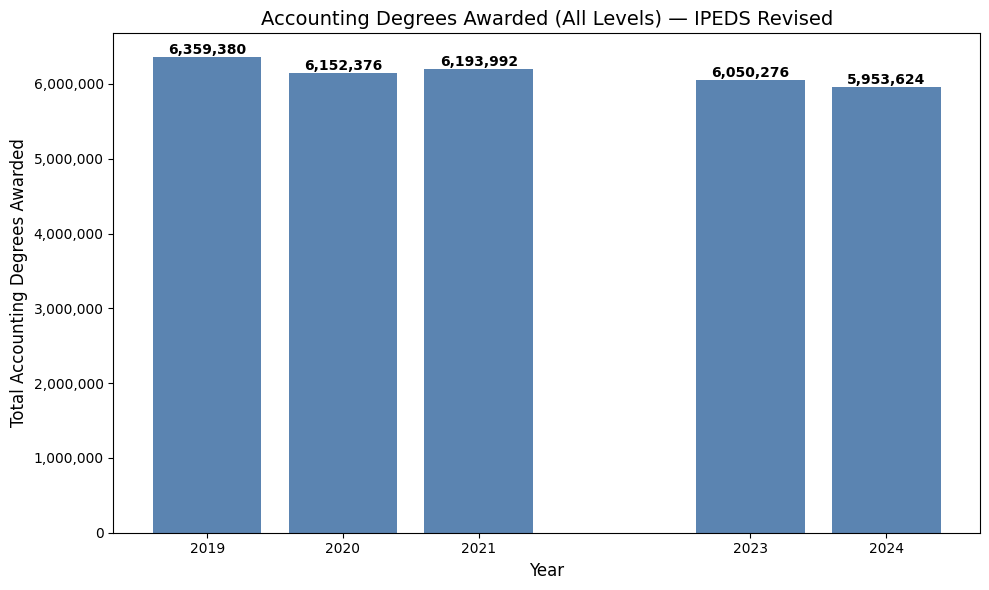

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 1. Make sure awards_total exists (sum of numeric award columns)
numeric_cols = completions_all.select_dtypes(include="number").columns
completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)

# 2. Filter Accounting degrees (CIP 52.0301)
acct = completions_all[completions_all["cipcode"] == "52.0301"]

acct_yearly = (
    acct.groupby("year")["awards_total"]
        .sum()
        .reset_index()
        .sort_values("year")
)

acct_yearly["year"] = acct_yearly["year"].astype(int)

# 3. Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(acct_yearly["year"], acct_yearly["awards_total"], color="#5b84b1ff")

plt.title("Accounting Degrees Awarded (All Levels) — IPEDS Revised", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Accounting Degrees Awarded", fontsize=12)
plt.xticks(acct_yearly["year"])

# Format Y axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## 6. Total degrees (all majors) — awards by year

Here we sum `awards_total` across **all CIP codes** to see how overall
degree production changes over time.


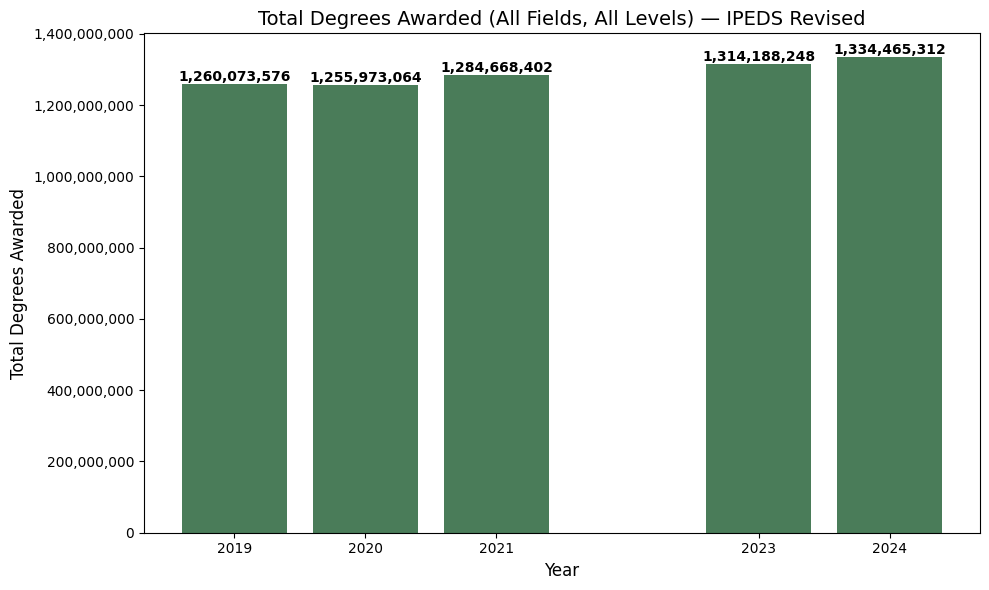

In [7]:
numeric_cols = completions_all.select_dtypes(include="number").columns
completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)

all_yearly = (
    completions_all.groupby("year")["awards_total"]
                   .sum()
                   .reset_index()
                   .sort_values("year")
)

all_yearly["year"] = all_yearly["year"].astype(int)

plt.figure(figsize=(10, 6))
bars = plt.bar(all_yearly["year"], all_yearly["awards_total"], color="#4a7c59")

plt.title("Total Degrees Awarded (All Fields, All Levels) — IPEDS Revised", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Degrees Awarded", fontsize=12)
plt.xticks(all_yearly["year"])

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## 7. Degree level trends (Bachelor’s vs Master’s)

We split degrees into:
- **All majors** vs **Accounting only (CIP 52.0301)**
- **Total awards**, **Bachelor’s (AWLEVEL 05)**, and **Master’s (AWLEVEL 07)**

Then we plot two line charts:
1. All majors by degree level
2. Accounting only by degree level


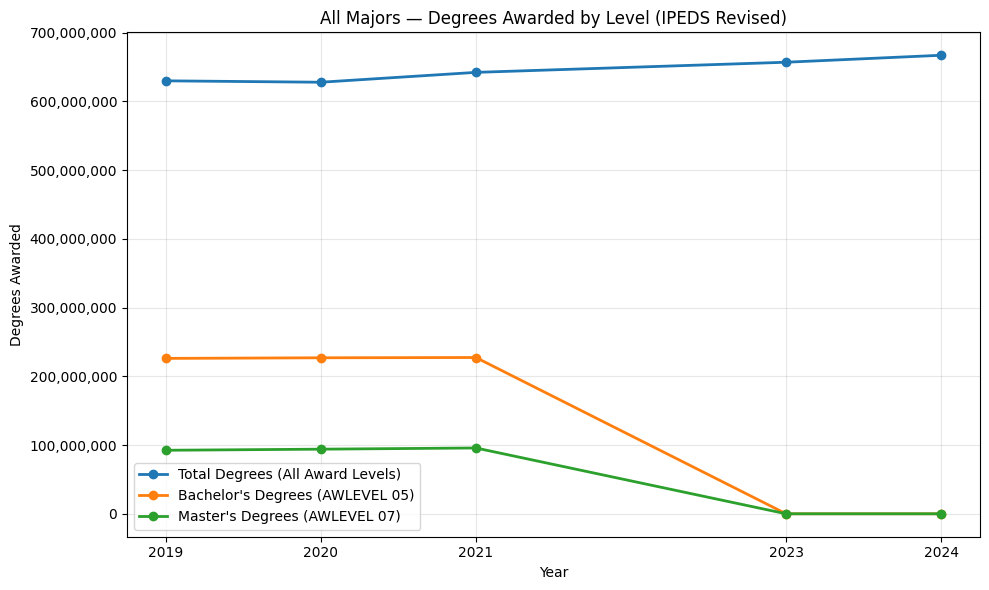

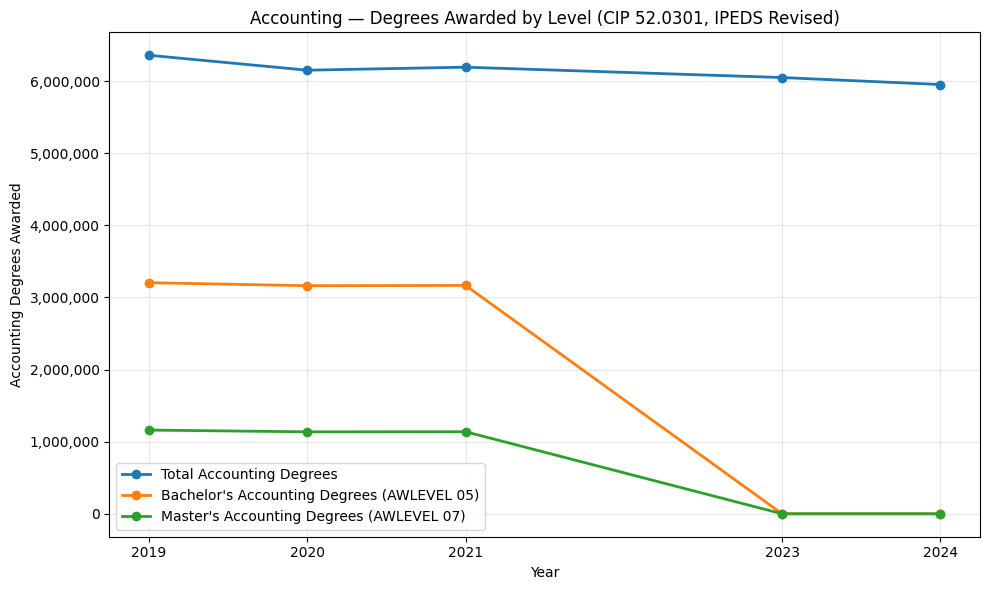

In [8]:
from matplotlib.ticker import FuncFormatter

# 1. Rebuild awards_total cleanly (avoid double-counting)
numeric_cols = completions_all.select_dtypes(include="number").columns.tolist()
if "awards_total" in numeric_cols:
    numeric_cols.remove("awards_total")

completions_all["awards_total"] = completions_all[numeric_cols].sum(axis=1)
completions_all["year"] = completions_all["year"].astype(int)

def build_yearly_degree_lines(df_subset: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a dataframe with columns:
    year, total_degrees, bachelors_degrees, masters_degrees
    """
    total = (
        df_subset.groupby("year")["awards_total"]
                 .sum()
                 .rename("total_degrees")
    )

    ba = (
        df_subset[df_subset["awlevel"] == "05"]
        .groupby("year")["awards_total"]
        .sum()
        .rename("bachelors_degrees")
    )

    ma = (
        df_subset[df_subset["awlevel"] == "07"]
        .groupby("year")["awards_total"]
        .sum()
        .rename("masters_degrees")
    )

    out = pd.concat([total, ba, ma], axis=1).fillna(0).reset_index()
    return out.sort_values("year")

# Build lines
all_majors_yearly = build_yearly_degree_lines(completions_all)
acct_only = completions_all[completions_all["cipcode"] == "52.0301"]
acct_yearly = build_yearly_degree_lines(acct_only)

formatter = FuncFormatter(lambda y, _: f"{int(y):,}")

# Graph 1: All majors
plt.figure(figsize=(10, 6))

plt.plot(all_majors_yearly["year"], all_majors_yearly["total_degrees"],
         marker="o", linewidth=2, label="Total Degrees (All Award Levels)")
plt.plot(all_majors_yearly["year"], all_majors_yearly["bachelors_degrees"],
         marker="o", linewidth=2, label="Bachelor's Degrees (AWLEVEL 05)")
plt.plot(all_majors_yearly["year"], all_majors_yearly["masters_degrees"],
         marker="o", linewidth=2, label="Master's Degrees (AWLEVEL 07)")

plt.title("All Majors — Degrees Awarded by Level (IPEDS Revised)")
plt.xlabel("Year")
plt.ylabel("Degrees Awarded")
plt.xticks(all_majors_yearly["year"])
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Graph 2: Accounting only
plt.figure(figsize=(10, 6))

plt.plot(acct_yearly["year"], acct_yearly["total_degrees"],
         marker="o", linewidth=2, label="Total Accounting Degrees")
plt.plot(acct_yearly["year"], acct_yearly["bachelors_degrees"],
         marker="o", linewidth=2, label="Bachelor's Accounting Degrees (AWLEVEL 05)")
plt.plot(acct_yearly["year"], acct_yearly["masters_degrees"],
         marker="o", linewidth=2, label="Master's Accounting Degrees (AWLEVEL 07)")

plt.title("Accounting — Degrees Awarded by Level (CIP 52.0301, IPEDS Revised)")
plt.xlabel("Year")
plt.ylabel("Accounting Degrees Awarded")
plt.xticks(acct_yearly["year"])
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
